<a href="https://colab.research.google.com/github/MetroPlays/Plant_Classifier/blob/main/Plant_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.8 MB/s 
     |████████████████████████████████| 189 kB 35.6 MB/s 
     |████████████████████████████████| 1.2 MB 35.4 MB/s 
     |████████████████████████████████| 48 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 
     |████████████████████████████████| 558 kB 48.2 MB/s 
     |████████████████████████████████| 51 kB 312 kB/s 
     |████████████████████████████████| 130 kB 52.9 MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!ls /content/gdrive/MyDrive/Colab\ Notebooks/Plant_Images

My_Test_Set  plants


In [ ]:
#Azure key do not commit with key filled out!
key='key'

#Testing a few plants with key
zebra_test = search_images_bing(key, 'aphelandra squarrosa')
spider_test = search_images_bing(key, 'spider plant')

im1 = zebra_test.attrgot('thumbnailUrl')
im2 = spider_test.attrgot('thumbnailUrl')

print(len(im1))
print(im1[0], im1[1])
print(len(im2))
print(im2[0], im2[1])

150
https://tse4.mm.bing.net/th?id=OIP.GN4sEoGxjLlcEIYQbNz62gHaFU&pid=Api https://tse2.mm.bing.net/th?id=OIP.p-k-r4oJpVXzkRIobSmNnwHaJ4&pid=Api
150
https://tse4.mm.bing.net/th?id=OIP.CbWL03lcwosE7HogjpPp4wHaFj&pid=Api https://tse3.mm.bing.net/th?id=OIP.-H4_S38cF0Z9dMRlRrwKOQHaJ4&pid=Api


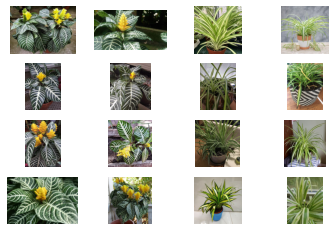

In [ ]:
f, axes = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
      if j < 2:
        image_data = requests.get(im1[i+4*j])
        image_data.raise_for_status()
        image = Image.open(BytesIO(image_data.content))        
        axes[i][j].imshow(image)
        axes[i][j].axis("off")
      else: 
        image_data = requests.get(im2[i+4*j])
        image_data.raise_for_status()
        image = Image.open(BytesIO(image_data.content))        
        axes[i][j].imshow(image)
        axes[i][j].axis("off")   
plt.show()

In [ ]:
export_path = Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images')

plant_types = ['aphelandra squarrosa', 'heart shaped philodendron', 'string of pearls', "baby's tears", 'monstera plants', 'spider plant', 'jade plant', 'chinese evergreen', 'small-leaf spiderwort', 'weeping fig', 'aloe vera', 'coppertone sedum', 'chin cactus', 'tiger lily', 'flax plant', 'poppy flower', 'tulips', 'mexican marigold']

path = export_path/'plants'

if not path.exists():
  path.mkdir()
  for plant in plant_types:
    save_to = (path/plant)
    save_to.mkdir(exist_ok=True)
    images = search_images_bing(key, plant)
    download_images(save_to, urls=images.attrgot('contentUrl'))

In [ ]:
# Fix file name, add jpg suffix
for plant in plant_types:
  dest = (path/plant)
  for filename in dest.ls():
    filename.rename((filename.parent/f"{filename.stem}.jpg"))

In [ ]:
fns = get_image_files(path)
fns

(#2333) [Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/plants/aphelandra squarrosa/00000000.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/plants/aphelandra squarrosa/00000001.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/plants/aphelandra squarrosa/00000007.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/plants/aphelandra squarrosa/00000005.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/plants/aphelandra squarrosa/00000004.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/plants/aphelandra squarrosa/00000003.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/plants/aphelandra squarrosa/00000013.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/plants/aphelandra squarrosa/00000009.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/plants/aphelandra squarrosa/00000017.jpg'),Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/plants/aphelan

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink)

(#0) []

18 different types of plants data loaded through azure and filtered and manually checked

Now for the model itself

In [ ]:
plant_dataBlock = DataBlock(blocks=(ImageBlock, CategoryBlock), get_items=get_image_files_sorted, splitter=RandomSplitter(valid_pct=0.2, seed=82), get_y=parent_label, item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())

In [ ]:
dls = plant_dataBlock.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


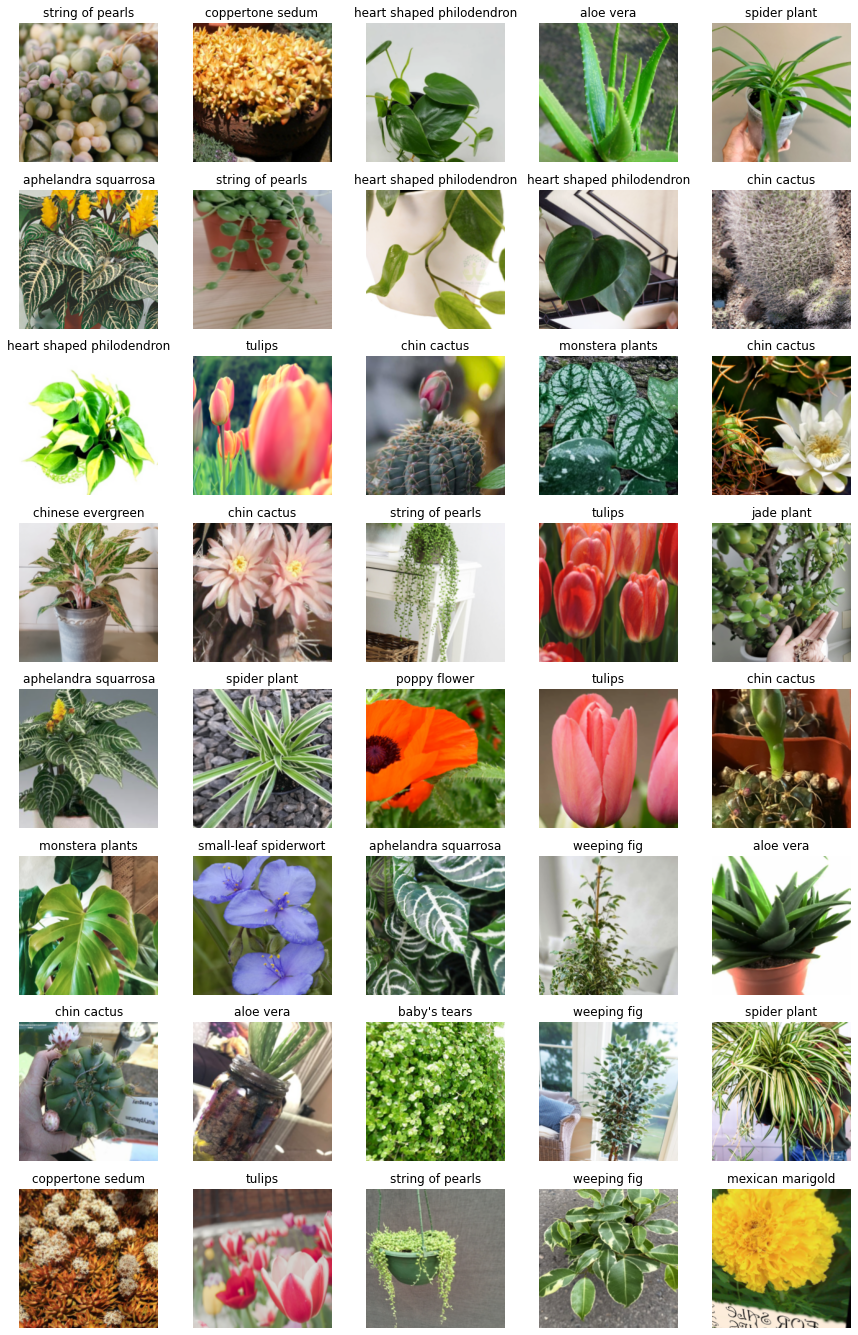

In [ ]:
dls.train.show_batch(max_n = 40, nrows=8)

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.824354,0.686235,0.212446,11:27


epoch,train_loss,valid_loss,error_rate,time
0,0.886111,0.365319,0.096567,16:23
1,0.594355,0.332314,0.094421,15:36


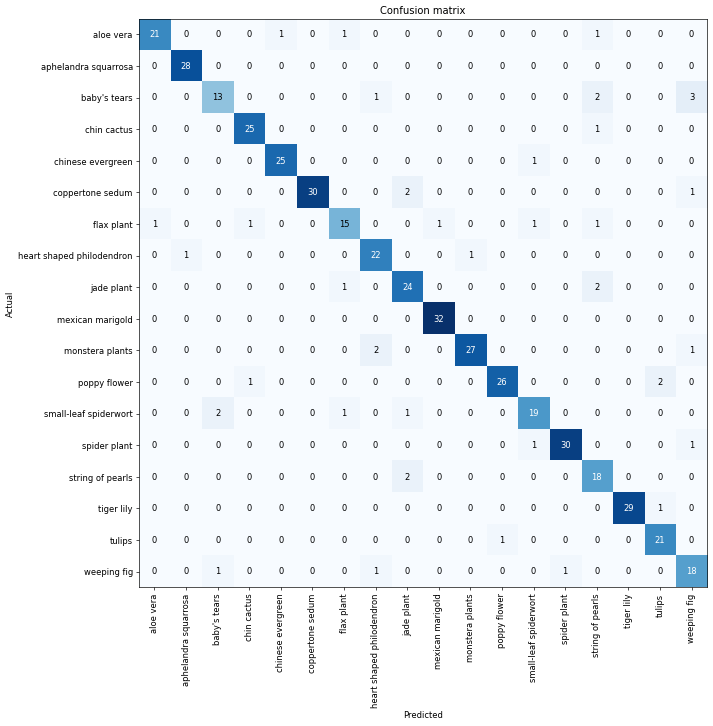

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=3)

[("baby's tears", 'weeping fig', 3)]

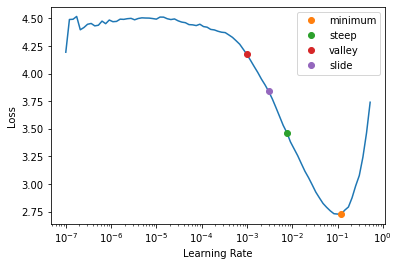

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [21]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, lr=0.01)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,2.695595,0.789746,0.218884,02:06


epoch,train_loss,valid_loss,error_rate,time
0,0.882366,0.511650,0.139485,02:11
1,0.659086,0.356209,0.100858,02:10
2,0.481173,0.320893,0.096567,02:10
3,0.362670,0.236140,0.064378,02:11
4,0.264752,0.234195,0.064378,02:10
5,0.190940,0.247524,0.068670,02:10
6,0.139447,0.229539,0.055794,02:10
7,0.101942,0.229019,0.057940,02:10
8,0.083451,0.222784,0.053648,02:11
9,0.068754,0.221778,0.053648,02:11


In [23]:
#Exporting 10 epoch model, will need to retrain with more epochs thinking 20
if not (export_path/'models').exists():
  (export_path/'models').mkdir()

learn.export(fname=(export_path/"models/10epoch_plants.pkl"))

In [24]:
#Again for .pth
learn.path = export_path
learn.save("10epoch_plants")

Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/models/10epoch_plants.pth')

In [25]:
(export_path/"models").ls()

(#2) [Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/models/10epoch_plants.pkl'),Path('/content/gdrive/MyDrive/Colab Notebooks/Plant_Images/models/10epoch_plants.pth')]